# Testing the Hamiltonian

Import the packages and the pre-calculated Hamiltonian:

In [56]:
import numpy as np
import sympy
import pickle
import matplotlib.pyplot as plt

with open("hamiltonians.py", 'rb') as f:
    hamiltonians = pickle.load(f)

Construct a list of basis states:

In [57]:
class BasisState:
    # constructor
    def __init__(self, J, mJ, I1, m1, I2, m2):
        self.J, self.mJ  = J, mJ
        self.I1, self.m1 = I1, m1
        self.I2, self.m2 = I2, m2

    # equality testing
    def __eq__(self, other):
        return self.J==other.J and self.mJ==other.mJ \
                    and self.I1==other.I1 and self.I2==other.I2 \
                    and self.m1==other.m1 and self.m2==other.m2

    # inner product
    def __matmul__(self, other):
        if self == other:
            return 1
        else:
            return 0

    # superposition: addition
    def __add__(self, other):
        if self == other:
            return State([ (2,self) ])
        else:
            return State([
                (1,self), (1,other)
            ])

    # superposition: subtraction
    def __sub__(self, other):
        return self + (-1)*other

    # scalar product (psi * a)
    def __mul__(self, a):
        return State([ (a, self) ])

    # scalar product (a * psi)
    def __rmul__(self, a):
        return self * a
    
    def print_quantum_numbers(self):
        print( self.J,"%+d"%self.mJ,"%+0.1f"%self.m1,"%+0.1f"%self.m2 )
        
half = sympy.Rational(1,2)
Jmax = sympy.Integer(6) # max J value in Hamiltonian
I_Tl = half             # I1 in Ramsey's notation
I_F  = half             # I2 in Ramsey's notation

def ni_range(x0, x1, dx=1):
    # sanity check arguments
    if dx==0:
        raise ValueError("invalid parameters: dx==0")
    if x0>x1 and dx>=0:
        raise ValueError("invalid parameters: x0>x1 and dx>=0")
    if x0<x1 and dx<=0:
        raise ValueError("invalid parameters: x0<x1 and dx<=0")
        
    # generate range list
    range_list = []
    x = x0
    while x < x1:
        range_list.append(sympy.Number(x))
        x += dx
    return range_list

QN = [BasisState(J,mJ,I_Tl,m1,I_F,m2)
      for J  in ni_range(0, Jmax+1)
      for mJ in ni_range(-J,J+1)
      for m1 in ni_range(-I_Tl,I_Tl+1)
      for m2 in ni_range(-I_F,I_F+1)
     ]

Convert the `sympy` `Matrix` into a `numpy` array:

In [58]:
variables = [
    sympy.symbols('Brot'),
    *sympy.symbols('c1 c2 c3 c4'),
    sympy.symbols('D_TlF'),
    *sympy.symbols('mu_J mu_Tl mu_F')
]

lambdified_hamiltonians = {
    H_name : sympy.lambdify(variables, H_matrix)
    for H_name, H_matrix in hamiltonians.items()
}

Insert the numerical constants:

In [59]:
Brot = 6689920000
c1 = 126030.0
c2 = 17890.0
c3 = 700.0
c4 = -13300.0
D_TlF = 4.2282 * 0.393430307 *5.291772e-9/4.135667e-15 # [Hz/(V/cm)]
mu_J = 35
mu_Tl = 1240.5
mu_F = 2003.63

H = {
    H_name : H_fn(
        Brot,
        c1, c2, c3, c4,
        D_TlF,
        mu_J, mu_Tl, mu_F
    )
    for H_name, H_fn in lambdified_hamiltonians.items()
}

## Zoomed-out view of the Hamiltonian

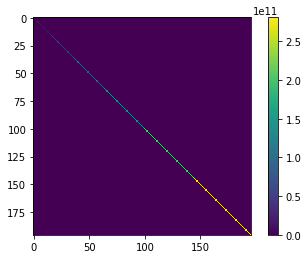

In [60]:
plt.imshow(H["Hff"])
plt.colorbar()

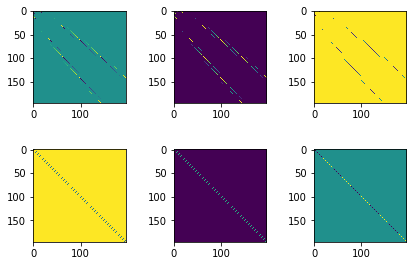

In [61]:
fig, axs = plt.subplots(2, 3);
fig.tight_layout();
axs[0,0].imshow(H["HSx"]);
axs[0,1].imshow(np.abs(H["HSy"]));
axs[0,2].imshow(H["HSz"]);
axs[1,0].imshow(H["HZx"]);
axs[1,1].imshow(np.abs(H["HZy"]));
axs[1,2].imshow(H["HZz"]);

### Find the energies

Above, we have evaluated the matrix elements for the zero-field Hamiltonian $H_\text{ff}$, as well as the $\vec E=1=\vec B$ cases. For general fields $\vec E,\vec B$, the Hamiltonian is

$$
H=H_\text{ff}
+
\begin{pmatrix}
E_x\\E_y\\E_z
\end{pmatrix}
\cdot
\begin{pmatrix}
H^\text{S}_x\\H^\text{S}_y\\H^\text{S}_z
\end{pmatrix}
+
\begin{pmatrix}
B_x\\B_y\\B_z
\end{pmatrix}
\cdot
\begin{pmatrix}
H^\text{Z}_x\\H^\text{Z}_y\\H^\text{Z}_z
\end{pmatrix}.
$$

When looking at the Zeeman/Stark effects on the hyperfine structure, the rotational structure is not of interest, so I subtract it for clarity in the following `spectrum()` function. It evaluates the above Hamiltonian for each point on the array of fields, and returns a list of energy levels, sorted by size:

In [62]:
def spectrum(Ex_arr,Ey_arr,Ez_arr,Bx_arr,By_arr,Bz_arr):
    energies_arr = []
    for Ex,Ey,Ez,Bx,By,Bz in zip(Ex_arr,Ey_arr,Ez_arr,Bx_arr,By_arr,Bz_arr):
        HamE = H["Hff"] + \
            Ex*H["HSx"]  + Ey*H["HSy"] + Ez*H["HSz"] + \
            Bx*H["HZx"]  + By*H["HZy"] + Bz*H["HZz"]
        D = np.sort(np.linalg.eigvalsh(HamE))
        
        # Subtract away rotational energy for easier viewing of substructure
        hfs_mat = []
        for i,psi in enumerate(QN):
            hfs_mat.append(D[i] - psi.J*(psi.J +1)*Brot)
        hfs_kHz = np.array(hfs_mat)/1000

        energies_arr.append(hfs_kHz)
    return np.array(energies_arr)

### Test 1: Reproducing Ramsey's Fig. 4

That's how it's supposed to look at 18.4 gauss of $B_z$:

![ramsey4](ramsey4.png)

Evaluate find the energies for $B_z$ of 18.4 gauss, and $E_z$ between 0 and 70 V/cm, and plot the result:

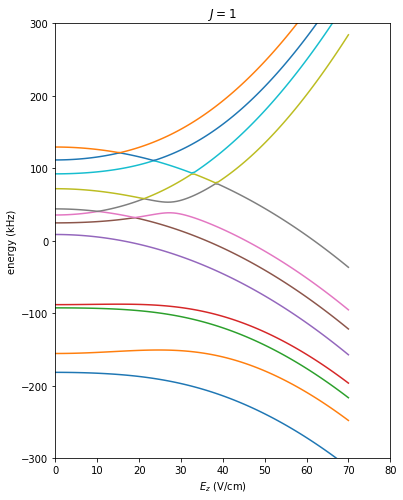

In [63]:
Ez = np.linspace(0,70,100)
Bz = 18.4 * np.ones(Ez.shape)
Ex = np.zeros(Ez.shape)
Ey = np.zeros(Ez.shape)
Bx = np.zeros(Ez.shape)
By = np.zeros(Ez.shape)

energies = spectrum(Ex,Ey,Ez,Bx,By,Bz)

for i in range(4,16):
    plt.plot(Ez, energies.T[i])
    
plt.title("$J=1$")
plt.xlabel("$E_z$ (V/cm)")
plt.ylabel("energy (kHz)")

plt.xlim([0,80])
plt.ylim([-300,300])

fig = plt.gcf()
fig.set_size_inches(6, 8)
plt.show()

### Test 2: Avoided crossings in the $J=2$ manifold

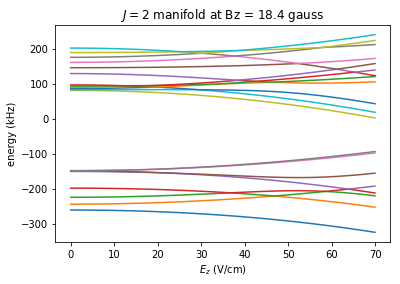

In [75]:
Ez = np.linspace(0,70,100)
Bz = 18.4 * np.ones(Ez.shape)
Ex = np.zeros(Ez.shape)
Ey = np.zeros(Ez.shape)
Bx = np.zeros(Ez.shape)
By = np.zeros(Ez.shape)

energies = spectrum(Ex,Ey,Ez,Bx,By,Bz)

for i in range(16,16+20):
    plt.plot(Ez, energies.T[i], label=i)
    
plt.title("$J=2$ manifold at Bz = 18.4 gauss")
plt.xlabel("$E_z$ (V/cm)")
plt.ylabel("energy (kHz)");

## Export in other formats

LaTeX:

In [47]:
from sympy.printing.latex import LatexPrinter
l = LatexPrinter()
with open("Hff.tex", "w") as f:
    f.write(l.doprint(hamiltonians["Hff"]))

Text:

In [55]:
with open("Hff.txt", "w") as f:
    f.write(str(hamiltonians["Hff"]))